In [1]:
from pathlib import Path
from tqdm import tqdm
import sys
from multiprocessing import Pool

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("default")
WORK_DIR = Path().absolute()
sys.path.append(str(WORK_DIR.parent))

In [2]:
from energyvslatconst import energyvslatconst, equilibrate_graphene

In [3]:
# Read setting file
ROOT_DIR = WORK_DIR.parent
with open(ROOT_DIR / "settings.json", "r") as f:
    settings = json.load(f)
partition = settings["partition"]
RES_DIR = WORK_DIR / "results" / f"{partition}_partition"
if not RES_DIR.exists():
    RES_DIR.mkdir(parents=True)

In [4]:
##########################################################################################
# Dropout
# -------

dropout_data = np.load(
    WORK_DIR.parent
    / "training_dropout"
    / "results"
    / "dropout"
    / f"{partition}_partition"
    / "uncertainty_energy_vs_latconst_diamond.npz"
)
alist = dropout_data["alist"]
energy_ensembles_do = dropout_data["energy_ensembles"]
energy_mean_do = np.mean(energy_ensembles_do, axis=0)
energy_error_do = np.std(energy_ensembles_do, axis=0)

In [5]:
##########################################################################################
# Bootstrap
# ---------
# Compute the energy ensembles
preds_samples_file = RES_DIR / "uncertainty_energy_vs_latconst_diamond.npz"
if preds_samples_file.exists():
    preds_data = np.load(preds_samples_file)
    energy_ensembles = preds_data["energy_ensembles"]
else:
    # energy_ensembles = np.empty((0, len(alist)))
    # for set_idx in tqdm(range(100)):
    #     # Predictions
    #     modelname = f"DUNN_C_bootstrap_{set_idx:03d}"
    #     _, elist, _ = energyvslatconst(modelname, alist, apply_dropout=False)
    #     energy_ensembles = np.row_stack((energy_ensembles, elist))
    # energy_ensembles = energy_ensembles.astype(float)
    # np.savez(preds_samples_file, alist=alist, energy_ensembles=energy_ensembles)
    
    # Use multiprocessing to speed up the calculation
    def energyvslatconst_wrapper(set_idx):
        modelname = f"DUNN_C_bootstrap_{set_idx:03d}"
        _, elist, _ = energyvslatconst(modelname, alist, "diamond", 0)
        return elist

    with Pool(25) as p:
        energy_ensembles = list(p.map(energyvslatconst_wrapper, range(100)))

    energy_ensembles = energy_ensembles = np.array(energy_ensembles).astype(float)
    np.savez(preds_samples_file, alist=alist, energy_ensembles=energy_ensembles)

In [6]:
energy_mean_bs = np.mean(energy_ensembles, axis=0)
energy_error_bs = np.std(energy_ensembles, axis=0)

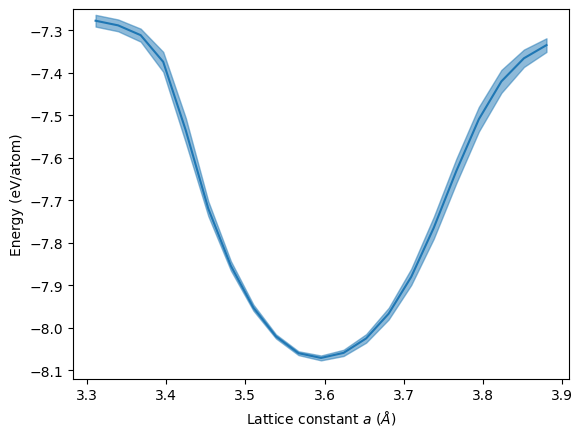

In [7]:
# Plot the result curves
# Energy vs lattice constant
plt.figure()

# Bootstrap
plt.fill_between(
    alist,
    energy_mean_bs - energy_error_bs,
    energy_mean_bs + energy_error_bs,
    alpha=0.5,
    color="tab:blue",
)
plt.plot(alist, energy_mean_bs, "-", color="tab:blue", label="DUNN bootstrap")

# # Dropout
# plt.fill_between(
#     alist,
#     energy_mean_do - energy_error_do,
#     energy_mean_do + energy_error_do,
#     alpha=0.5,
#     color="tab:orange",
# )
# plt.plot(alist, energy_mean_do, "-", color="tab:orange", label="DUNN dropout")
plt.ylim(-8.12, -7.25)
plt.xlabel(r"Lattice constant $a$ $(\AA)$")
plt.ylabel("Energy (eV/atom)")
# plt.legend()

plt.show()
